In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset

In [7]:
# Load the datasets from HuggingFace
task_names = ["bolt insertion easy", "bolt insertion hard", "bolt sorting", "bearing insertion"]
repo_ids = [
    "F-Fer/ur-task1",
    "F-Fer/ur-task2",
    "F-Fer/ur-task3",
    "F-Fer/ur-task4",
]

datasets = {}
for name, repo_id in zip(task_names, repo_ids):
    print(f"Loading {repo_id}...")
    datasets[name] = load_dataset(repo_id, split="train")
    print(f"  Loaded {len(datasets[name])} frames")

Loading F-Fer/ur-task1...
  Loaded 275367 frames
Loading F-Fer/ur-task2...
  Loaded 437176 frames
Loading F-Fer/ur-task3...
  Loaded 140169 frames
Loading F-Fer/ur-task4...
  Loaded 327458 frames


In [8]:
# Calculate episode durations
# LeRobot datasets have 'episode_index' and 'timestamp' columns
def get_episode_durations(dataset):
    """Calculate duration of each episode in seconds."""
    df = dataset.to_pandas()
    
    # Group by episode and get duration (max timestamp - min timestamp per episode)
    episode_durations = df.groupby("episode_index")["timestamp"].agg(
        lambda x: x.max() - x.min()
    )
    return episode_durations.values

task_durations = {}
for name, ds in datasets.items():
    durations = get_episode_durations(ds)
    task_durations[name] = {
        "durations": durations,
        "mean": np.mean(durations),
        "std": np.std(durations),
        "num_episodes": len(durations),
    }
    print(f"{name}: {task_durations[name]['num_episodes']} episodes, "
          f"avg duration: {task_durations[name]['mean']:.2f}s ± {task_durations[name]['std']:.2f}s")

bolt insertion easy: 200 episodes, avg duration: 22.93s ± 3.63s
bolt insertion hard: 200 episodes, avg duration: 36.41s ± 6.78s
bolt sorting: 200 episodes, avg duration: 11.66s ± 5.29s
bearing insertion: 200 episodes, avg duration: 27.27s ± 4.05s


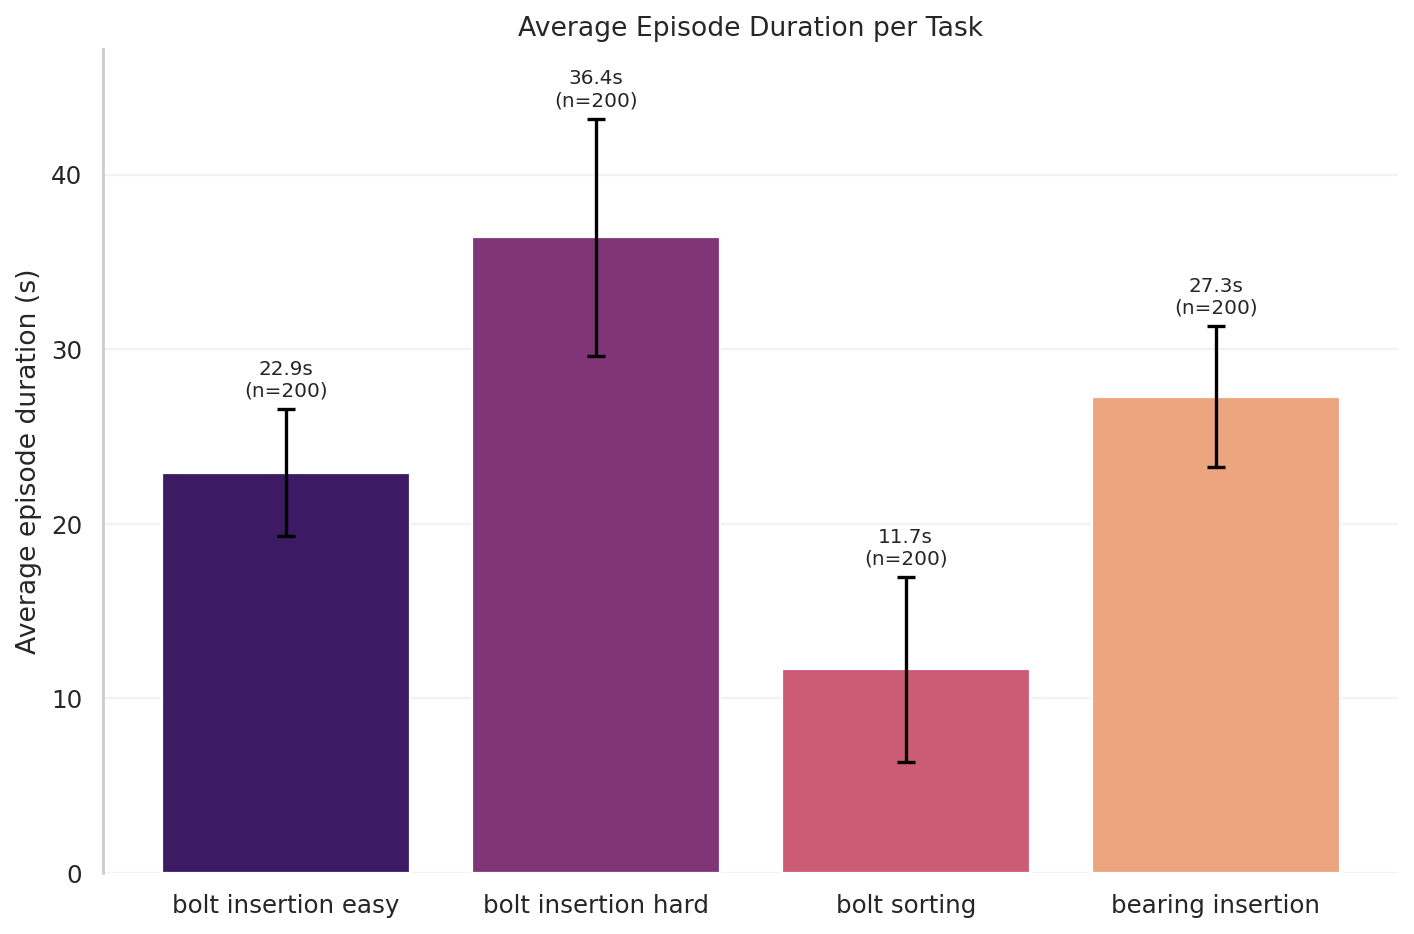

In [12]:
sns.set_theme(style="whitegrid")
plt.rcParams.update({"font.size": 12})

# Prepare data
labels = list(task_durations.keys())
means = [task_durations[t]["mean"] for t in labels]
stds = [task_durations[t]["std"] for t in labels]
num_episodes = [task_durations[t]["num_episodes"] for t in labels]

fig, ax = plt.subplots(figsize=(9, 6), dpi=160)
palette = sns.color_palette("magma", len(labels))

bars = sns.barplot(x=labels, y=means, ax=ax, hue=labels, palette=palette, legend=False)

# Add error bars
x_positions = [bar.get_x() + bar.get_width() / 2 for bar in ax.patches]
ax.errorbar(x_positions, means, yerr=stds, fmt="none", c="black", capsize=4, capthick=1.5)

ax.set_ylabel("Average episode duration (s)")
ax.set_xlabel("")
ax.set_title("Average Episode Duration per Task")

# Add annotations
for bar, mean, std, n in zip(ax.patches, means, stds, num_episodes):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + std + 0.5,
        f"{mean:.1f}s\n(n={n})",
        ha="center",
        va="bottom",
        fontsize=9,
    )

ax.set_ylim(0, max(means) + max(stds) + 4)
ax.grid(axis="y", alpha=0.25)
sns.despine(ax=ax, left=False, bottom=True)
plt.tight_layout()
plt.show()

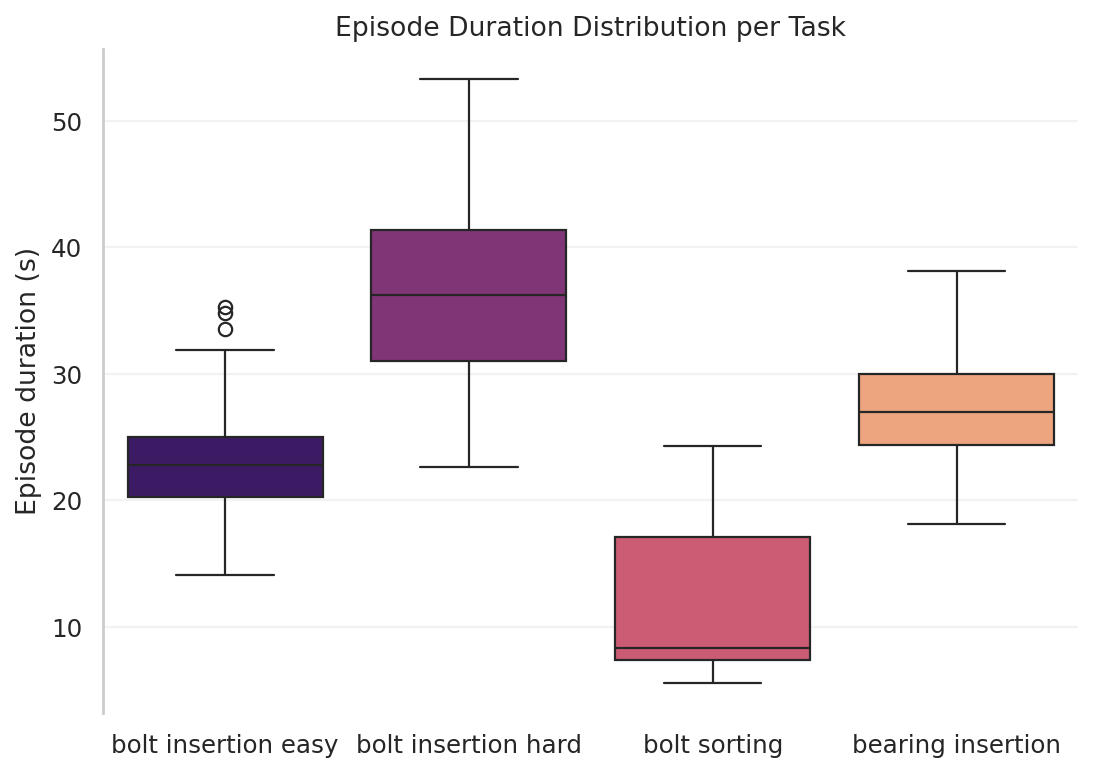

In [10]:
# Additional plot: Distribution of episode durations per task (box plot)
fig, ax = plt.subplots(figsize=(7, 5), dpi=160)

# Prepare data for box plot
all_durations = []
all_labels = []
for name in labels:
    durations = task_durations[name]["durations"]
    all_durations.extend(durations)
    all_labels.extend([name] * len(durations))

sns.boxplot(x=all_labels, y=all_durations, ax=ax, hue=all_labels, palette=palette, legend=False)

ax.set_ylabel("Episode duration (s)")
ax.set_xlabel("")
ax.set_title("Episode Duration Distribution per Task")
ax.grid(axis="y", alpha=0.25)
sns.despine(ax=ax, left=False, bottom=True)
plt.tight_layout()
plt.show()